# Clustering of horror movies

Loading data previously cleaned in R

In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv("horror_movies_cleaned.csv")
movies

,title,story,director,cast,Action,Adventure,Comedy,Crime,Drama,Fantasy,Mystery,Romance,Sci-Fi,Thriller
0,Gut,Family man Tom has seen something he cant forg...,Elias,"Jason Vail, Nicholas Wilder, Sarah Schoofs, Ki...",0,0,0,0,1,0,0,0,0,1
1,Treasure Chest of Horrors II,"Mona Screamalot, along with her crazy family, ...","M Kelley, Shawn C Phillips, Alex Powers","Veronica Ricci, Nicholas Adam Clark, James Cul...",0,0,1,0,0,0,0,0,0,1
2,Infidus,"In the suburbs of Rome, two disparate lives wi...",Giulio De Santi,"Bonini Mino, Massimo Caratelli, Maurizio Zaffi...",0,0,0,1,1,0,0,0,0,0
3,In Extremis,Its the end of the world at least their world.,Steve Stone,"David OHara, Isabelle Allen, Neil Pearson, Toy...",0,0,0,0,0,0,0,0,0,1
4,Ghostlight,Andrew wins a radio contest to spend one night...,Jeff Ferrell,"Eden Campbell, Lisa Coronado, David A Crellin,...",0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,Victor Frankenstein,"Told from Igors perspective, we see the troubl...",Paul McGuigan,"Daniel Radcliffe, James McAvoy, Jessica Brown ...",0,0,0,0,1,0,0,0,1,1
3164,The Exorcism of Molly Hartley,Taking place years after The Haunting of Molly...,Steven R Monroe,"Sarah Lind, Devon Sawa, Gina Holden, Peter Mac...",0,0,0,0,0,0,0,0,0,0
3165,Talon Falls,Four teenagers on a road trip decide to take a...,Joshua Shreve,"Brad Bell, Jordyn Rudolph, Ryan Rudolph, Morga...",0,0,0,0,0,0,0,0,0,0
3166,BloodRayne: The Third Reich,Rayne fights against the Nazis in Europe durin...,Uwe Boll,"Natassia Malthe, Brendan Fletcher, Michael Par...",1,1,0,0,0,1,0,0,0,0


## Tokenization of plots

Stoppord, tokens, lowercasing, möjligen lemmatisering.

In [2]:
# Using things from lab 1
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")
stop_words = ["the", "a", "in", "but", "when", "s", "be", "can"]

def preprocess(text):
    doc = nlp(text)
    
    ret_list = [token.lemma_.lower() for token  in doc if not token.is_stop and token.lemma_.lower() not in stop_words]
    return list(filter(lambda x: x.isalpha(), ret_list))

movies["token_plot"] = movies.apply(lambda row: preprocess(row["story"]), axis = 1)
movies["token_title"] = movies.apply(lambda row: preprocess(row["title"]), axis = 1)
movies["token_title_plot"] = movies.apply(lambda row: row["token_title"] + row["token_plot"], axis = 1)

In [109]:
tid = 3011
print(movies.token_plot[tid])
print(movies.token_title[tid])
print(movies.token_title_plot[tid])
print(movies.story[tid])

['resident', 'coastal', 'town', 'learn', 'deathly', 'consequence', 'secret', 'share', 'mysterious', 'woman', 'seek', 'shelter', 'local', 'resort']
['byzantium']
['byzantium', 'resident', 'coastal', 'town', 'learn', 'deathly', 'consequence', 'secret', 'share', 'mysterious', 'woman', 'seek', 'shelter', 'local', 'resort']
Residents of a coastal town learn, with deathly consequences, the secret shared by the two mysterious women who have sought shelter at a local resort.


In [29]:
# Funkar inte just nu, måste ha både splittad lista och mening lagrad nånstans...
vectorizer_p = TfidfVectorizer(stop_words = 'english')
plots_tfidf = vectorizer_p.fit_transform(movies.apply(lambda row: " ".join(row["token_plot"]), axis=1))
vectorizer_tp = TfidfVectorizer(stop_words = 'english')
title_plots_tfidf = vectorizer_tp.fit_transform(movies.apply(lambda row: " ".join(row["token_title_plot"]), axis=1))

## K-means-clustering

### Tuning number of clusters

In [31]:
from sklearn.cluster import KMeans

def inertia(model, data):
    dists = model.transform(data)
    min_dist = np.amin(dists, axis = 1)
    return sum(np.square(min_dist))


max_clus = 13

plot_models = [KMeans(n_clusters=nclus, n_init=6, n_jobs=-1, random_state = max_clus).fit(plots_tfidf) for nclus in range (6,max_clus)]
inertias = [inertia(model, plots_tfidf) for model in plot_models]

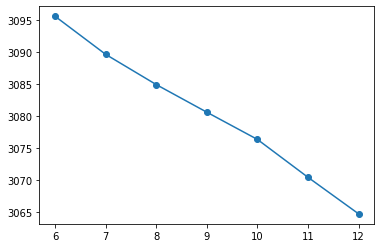

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(range(6,max_clus), inertias)
plt.plot(range(6,max_clus), inertias)
plt.show()

Elbow som i labben...

## Optics-clustering

In [55]:
from sklearn.cluster import DBSCAN

#optic_plots =  OPTICS(n_jobs=-1,  metric='cosine').fit(plots_tfidf.toarray())
dbs_plot = DBSCAN(n_jobs=-1,  eps=0.00000005, metric = "cosine").fit(plots_tfidf.toarray())

In [61]:
pd.Series(dbs_plot.labels_).value_counts()
plots_tfidf[0:3,0:3]

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

### Tuning eps and min.pts

Ska väl gå på nåt jäkla vis...

## Topic modelling

In [21]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Create a dictionary representation of the documents.
dictionary = Dictionary(movies["token_title_plot"])
dictionary.filter_extremes(no_below=5, no_above=0.2)
corpus_title = [dictionary.doc2bow(d) for d in movies["token_title_plot"]]
corpus_plot = [dictionary.doc2bow(d) for d in movies["token_plot"]]

In [25]:
print(dictionary)

Dictionary(2144 unique tokens: ['daily', 'family', 'forget', 'life', 'man']...)


In [22]:
ntopics = 10
nwords=15
#id2word = dictionary.id2token #suddenly returns empty and kills LAD... love python!
model_title = LdaModel(corpus_title, num_topics=ntopics, random_state=831117)
model_plot = LdaModel(corpus_plot, num_topics=ntopics, random_state=831117)

In [26]:
def topic_words(model):
    topics = model.show_topics(num_words=nwords, formatted=False,log=False)
    # Lookup directly from dictionary instead of id2token
    topic_words = pd.DataFrame([[dictionary[ int(topics[i][1][j][0]) ] for j in range(nwords) ] for i in range(ntopics)])
    return topic_words
    
words_title  = topic_words(model_title)
words_title


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,family,friend,world,come,find,not,night,zombie,group,lake,fight,evil,haunt,mysterious,after
1,young,find,house,woman,girl,group,friend,killer,man,family,vampire,life,horror,small,turn
2,young,house,home,year,couple,new,friend,family,find,evil,woman,day,night,child,town
3,house,group,home,young,haunt,night,find,friend,ghost,evil,death,film,family,take,begin
4,life,girl,man,find,young,discover,group,year,friend,deadly,fight,town,force,story,woman
5,killer,dark,young,zombie,not,friend,discover,man,force,woman,soon,story,group,find,family
6,find,man,young,night,woman,life,group,friend,story,dead,murder,mysterious,family,town,death
7,life,new,friend,killer,death,find,tale,horror,discover,year,young,story,past,strange,after
8,dead,find,night,zombie,family,human,discover,team,brother,life,live,group,evil,an,house
9,secret,young,murder,begin,dark,discover,find,life,family,soon,nightmare,start,uncover,quickly,boy


In [27]:
words_plot = topic_words(model_plot)
words_plot

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,family,friend,world,night,killer,find,come,town,group,zombie,mysterious,not,after,fight,victim
1,young,find,house,friend,girl,woman,group,killer,family,man,force,vampire,life,murder,mysterious
2,young,home,house,year,couple,woman,family,child,friend,new,haunt,day,find,evil,after
3,group,house,home,young,find,haunt,film,friend,ghost,night,begin,father,place,mysterious,take
4,life,girl,find,man,young,town,fight,group,turn,deadly,year,discover,try,force,woman
5,young,discover,family,soon,killer,group,dark,find,force,woman,story,not,friend,man,zombie
6,find,man,young,life,woman,group,night,friend,mysterious,story,town,help,family,new,soon
7,life,new,friend,death,find,horror,past,killer,discover,tale,strange,apartment,young,haunt,year
8,find,dead,family,night,discover,deadly,life,begin,evil,spirit,team,take,house,young,live
9,secret,murder,young,begin,dark,family,nightmare,discover,find,life,soon,new,as,turn,fall


### Evaluation

Dot-product av klustertillhörogheter?! Borde ge höga värden om de har lika klusterprobs, men kanske blir problem om man har nonsenskluster.
mappa topics till kategorier och jämföra med sanningen?

Även kolla coherence, jmf förekomster av topicord i dokumenten.